# An example of a microservice in Adama

This example can be run by checking out the repository

> https://github.com/waltermoreira/adama-example.git

and using `docker-compose up`.  See the [README](https://github.com/waltermoreira/adama-example/blob/master/README.rst) file for more details.

## Setting up

We use a development instance of Adama (the production one is https://api.araport.org).  Note that we are using HTTP instead of HTTPS and no authentication, since it's just a throw away sandbox.  This is, of course, **strongly discouraged**.

In [2]:
ADAMA = 'http://adama-dev.cloudapp.net/community/v0.3'

The first request is to check the status of the Adama server:

In [3]:
import requests
requests.get(ADAMA+'/status').json()

Since we'll be doing this a lot, we define a simple function to wrap this procedure:

In [6]:
def adama(endpoint):
    return requests.get(ADAMA+endpoint).json()

And now, the previous request is equivalent to:

In [7]:
adama('/status')

{u'api': u'Adama v0.3',
 u'hash': u'6424062cab3dc8bf18467ff276fa5027d71c8b8d',
 u'status': u'success'}

## Creating a namespace

Let's look at all the namespaces registered at the moment:

In [8]:
adama('/namespaces')

{u'result': [{u'description': None,
   u'name': u'demo',
   u'self': u'http://adama-dev.cloudapp.net/community/v0.3/demo',
   u'url': None,
   u'users': {u'anonymous': [u'POST', u'PUT', u'DELETE']}}],
 u'status': u'success'}

The first step in registering a service is to create a namespace.  Skip this step if you already have one.

We first delete it, just to demonstrate the creation of a new one:

In [13]:
requests.delete(ADAMA+'/demo')
requests.post(ADAMA+'/namespaces', data={'name': 'demo'})

<Response [200]>

The response should be 200.  Calling again `adama('/namespaces')` should reveal our new namespace.

## Creating a service

This container already contains a complete service that can be registered.  Look in the directory `/service`:

In [14]:
!ls /service

logo.png  main.py  metadata.yml


The file `main.py` contains the code of the service.  In this case, it is a simple call to a webservice at the Meyers Lab in the University of Delaware (https://mpss.udel.edu).

The file `metadata.yml` contains all the information for the service, such as its description, documentation, and provenance information:

In [15]:
!cat /service/metadata.yml

---

name: smallrna
version: 0.1
description: List of gene/IGR-specific reads and expression data

# authors of this service in Adama
# see provenance information below
authors:
  - name: Walter Moreira
    email: wmoreira@tacc.utexas.edu
    sponsor_organization_name: The University of Texas at Austin
    sponsor_uri: http://utexas.edu

# type of service
type: query
main_module: service/main.py

icon: logo.png

# domains the service will access to get the data
whitelist:
  - mpss.udel.edu

# allow Adama to validate parameters before sending them to the
# service
validate_request: true

# document the parameters for the endpoints
endpoints:
  /search:
    parameters:
      - name: gene
        description:
        type: string
        required: true
        default: AT1G01010
      - name: model
        description:
        type: string
        required: false
        default: 1
        enum:
          - '1'
          - '2'
          - '3'
          - '4'
          - '5'
          - '6

To register this service in Adama, we just have to point to the git repository where the source is located (again, we delete a previous service to demonstrate its creation).

The two parameters we pass to the POST request at `/demo/services` are:

- `git_repository`: the git repo where the source code is located,
- `metadata`: a directory (relative to the root of the git repository) where to find the file `metadata.yml`.

In [18]:
requests.delete(ADAMA+'/demo/smallrna_v0.1')

<Response [200]>

In [19]:
response = requests.post(ADAMA+'/demo/services',
             data={'git_repository': 'https://github.com/waltermoreira/adama-example.git',
                   'metadata': 'service'})
response.json()

{u'message': u'registration started',
 u'result': {u'list_url': u'http://adama-dev.cloudapp.net/community/v0.3/demo/smallrna_v0.1/list',
  u'notification': u'',
  u'search_url': u'http://adama-dev.cloudapp.net/community/v0.3/demo/smallrna_v0.1/search',
  u'state_url': u'http://adama-dev.cloudapp.net/community/v0.3/demo/smallrna_v0.1'},
 u'status': u'success'}

On success, we obtain information about the endpoints to use the service.

## Using the service

Once the service is registered in Adama, there are a number of operations that can be performed on it:

- [Finding documentation](#Finding-documentation)
- [Searching](#Searching)
- [Finding provenance](#Finding-provenance)
- [Finding stats](#Finding-stats)
- [Vanity icon](#Vanity-icon)

### Finding documentation

The endpoint `/docs` of the service provides a full description of its parameters:

In [25]:
print requests.get(ADAMA+'/demo/smallrna_v0.1/docs?format=yaml').text

basePath: !!python/unicode '/community/v0.3/demo/smallrna_v0.1'
definitions:
  Generic:
    properties:
      message:
        description: Human readable message
        type: string
      result:
        description: Result
        type: object
      status:
        description: Status of response
        enum:
        - success
        - error
        type: string
host: adama-dev.cloudapp.net
info:
  description: List of gene/IGR-specific reads and expression data
  title: 'Adapter: smallrna v0.1'
  version: 0.1
paths:
  /list:
    get:
      description: List all objects
      operationId: list_get
      parameters: []
      responses:
        '200':
          description: successful response
          schema:
            $ref: '#/definitions/Generic'
      summary: List
  /search:
    get:
      description: Do a search
      operationId: search_get
      parameters:
      - default: AT1G01010
        description: null
        in: query
        name: gene
        required: true
  

In the production server, documentation can be browsed at https://www.araport.org/api-explorer.  In the development server, documentation for this service can be seen at http://adama-dev.cloudapp.net/community/v0.3/demo/smallrna_v0.1/docs/swagger.

### Searching

Once the parameters for the search are known, we can execute the service by calling its `/search` endpoint:

In [27]:
response = requests.get(ADAMA+'/demo/smallrna_v0.1/search?gene=AT1G01010')

`response` contains the data returned by the service.  We display the first line of the result:

In [29]:
response.json()['result'][0]

{u'abundance_table': [{u'Col0': 0},
  {u'ddc': 0},
  {u'met1': 0},
  {u'rdd': 0},
  {u'Col0b': 0},
  {u'abh11': 0},
  {u'ein56': 0},
  {u'ein56abh11': 0},
  {u'SUr2a': 0},
  {u'SUr2b': 0},
  {u'SWT1': 0},
  {u'S234a': 0},
  {u'S234b': 0},
  {u'RMMT49': 0},
  {u'RMKS02': 0},
  {u'RMKS01': 0},
  {u'RMKS03': 0},
  {u'RMMT10': 0},
  {u'RMMT11': 0},
  {u'RMMT05': 0},
  {u'RMMT12': 0},
  {u'MTSRNA2': 0},
  {u'MTSRNA1': 0},
  {u'CxC5d': 0},
  {u'CxL5d': 0},
  {u'LxL5d': 0},
  {u'LxC5d': 0},
  {u'Cola': 0},
  {u'Colb': 0},
  {u'Colc': 0},
  {u'ago1a': 0},
  {u'ago1b': 0},
  {u'ago1c': 0},
  {u'Col7a': 0},
  {u'Col7b': 0},
  {u'Col7c': 0},
  {u'Col10a': 0},
  {u'Col10b': 0},
  {u'Col10c': 0},
  {u'dcl17a': 0},
  {u'dcl110a': 0},
  {u'dcl2347a': 0},
  {u'dcl23410a': 0},
  {u'dcl17b': 0},
  {u'dcl17c': 0},
  {u'dcl110b': 0},
  {u'dcl110c': 0},
  {u'dcl2347b': 0},
  {u'Col7d': 0},
  {u'dcl23410b': 0},
  {u'dcl23410c': 0},
  {u'TuMV7dpiA': 0},
  {u'TuMV7dpiB': 0},
  {u'TuMV7dpiC': 0},
  {u'TuMV10dp

### Finding provenance

Every result in Adama contains information about the sources of data.  The link is provided in the header in the standard format [PROV-N](http://www.w3.org/TR/prov-n/):

In [35]:
prov_link = response.links['http://www.w3.org/ns/prov#has_provenance']['url']
prov_link

'http://adama-dev.cloudapp.net/community/v0.3/demo/smallrna_v0.1/prov/e05c077e175b48bd9916c7c4198934e1'

This URL can be requested in several formats: `prov`, `prov-n`, `json`, `png`.  

Let's display the graph of provenance:

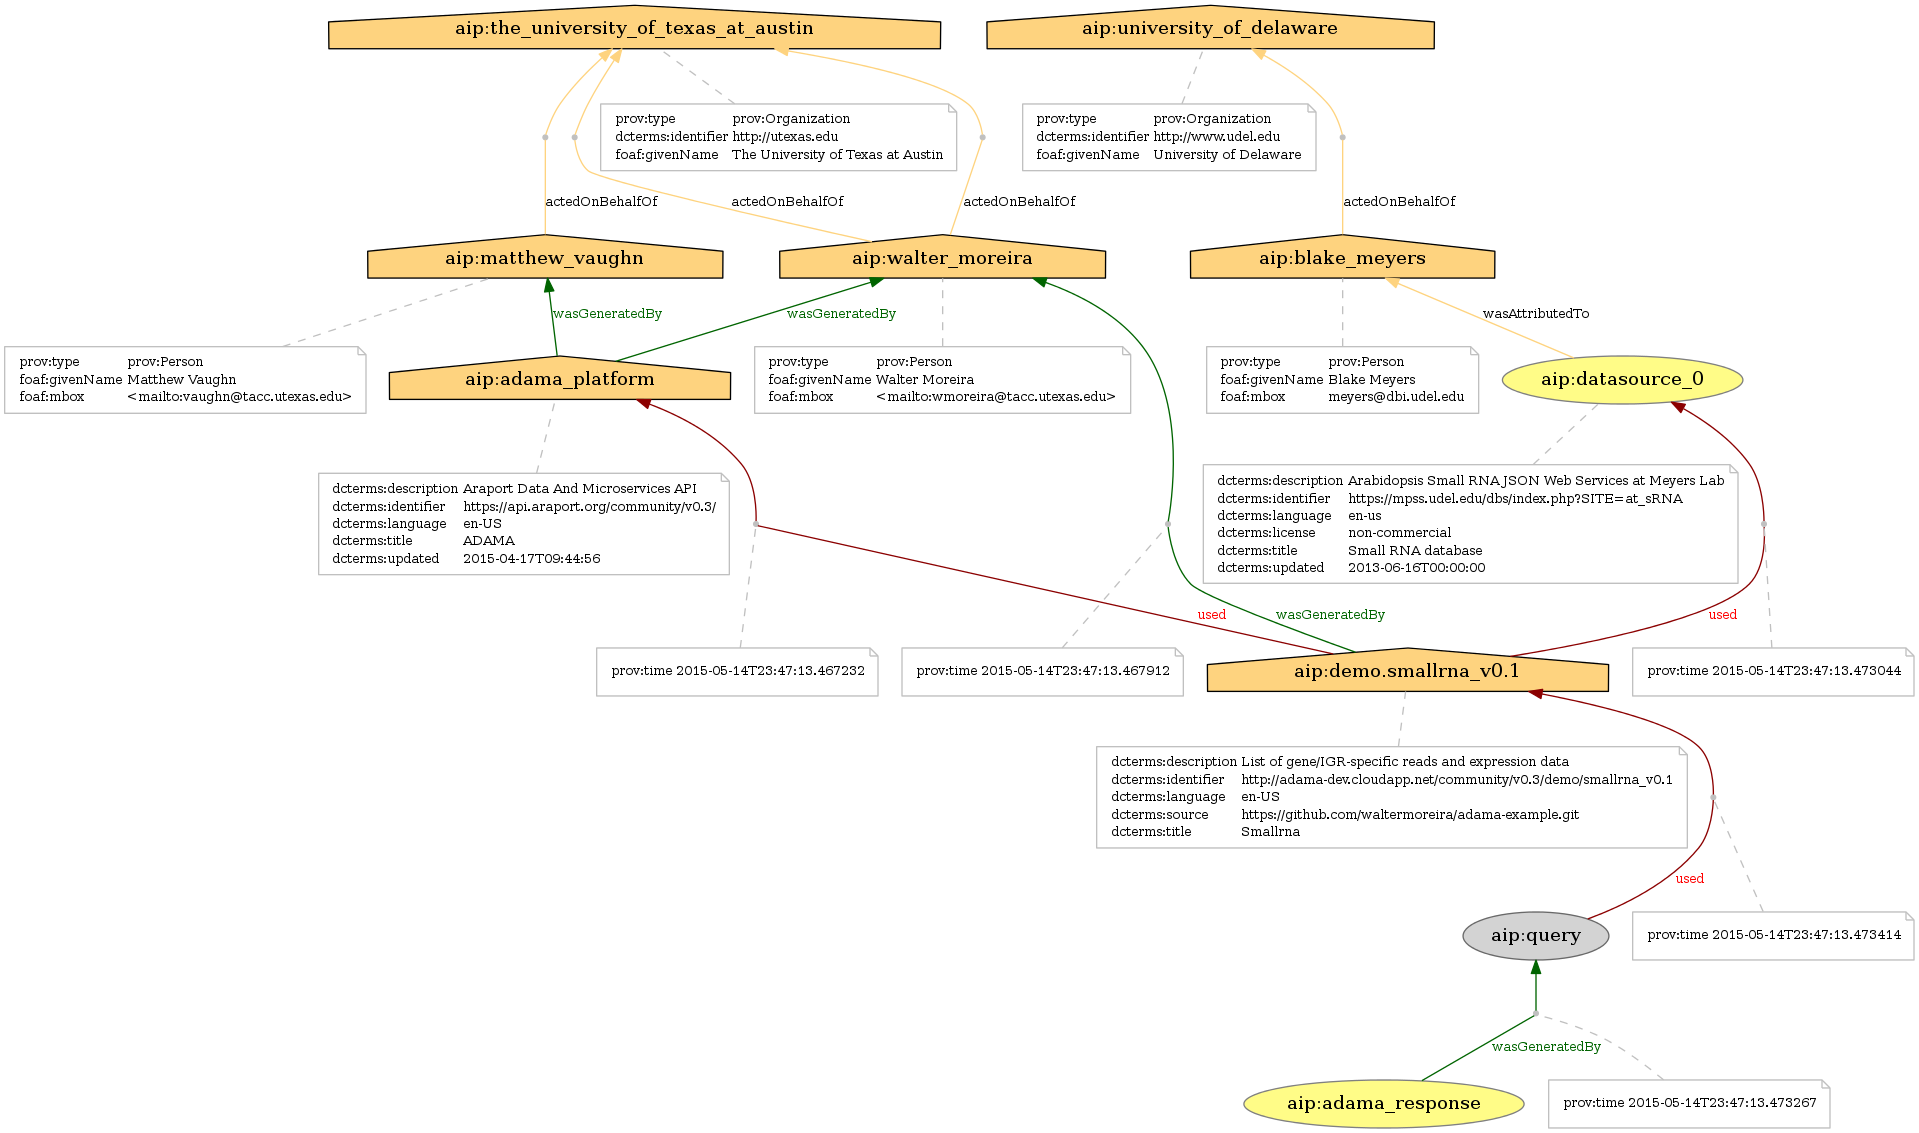

In [38]:
from IPython.display import Image

response = requests.get(prov_link+'?format=png')
Image(data=response.content)

### Finding stats

Services keep a record of the number of access by IP and by users:

In [39]:
adama('/demo/smallrna_v0.1/stats')

{u'status': u'success', u'total_access': 1, u'unique_access': 1, u'users': 1}

### Vanity icon

Since these services are meant to be consumed by front end applications, such as the scientific apps at https://araport.org, it is useful to associate a brand to them.  An icon can be requested at the endpoint `/icon`:

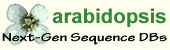

In [42]:
Image(data=requests.get(ADAMA+'/demo/smallrna_v0.1/icon').content)